In [25]:
import os
import sys
import mne
import time
import pickle
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mne.preprocessing import ICA, create_eog_epochs


In [26]:
root_folder = 'C:/Users/thiag/OneDrive - Georgia Institute of Technology/DEAP/data_original'
ratings_csv_path = 'C:/Users/thiag/OneDrive - Georgia Institute of Technology/DEAP/Metadata/metadata_csv/participant_ratings.csv' # os.path.join(os.getcwd(), 'metadata_csv', 'participant_ratings.csv')
DEAP_EEG_channels_xlsx_path = 'C:/Users/thiag/OneDrive - Georgia Institute of Technology/DEAP/Metadata/DEAP_EEG_channels.xlsx'

In [27]:
N_trials = 40
N_EEG_electrodes = 32
N_ICA = 8
N_BIPOLAR = 16
sfreq = 128


In [28]:
ICA_components_folder = os.path.join(os.getcwd(), 'results', 'ICA_components')
ICA_models_folder = os.path.join(os.getcwd(), 'results', 'ICA_models')
PSD_folder = os.path.join(os.getcwd(), 'results', 'PSD')
mneraw_as_pkl_folder = os.path.join(os.getcwd(), 'results', 'pkl')
npy_folder = os.path.join(os.getcwd(), 'results', 'npy')

In [29]:
for folder in [ICA_components_folder, ICA_models_folder, PSD_folder, mneraw_as_pkl_folder, npy_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)

In [30]:
def clean_bdf(subject_id):

    npy_path = os.path.join(npy_folder, 's{:02}.npy'.format(subject_id))
    if os.path.exists(npy_path):
        print('\nFile has already been preprocessed.\nSkipping EEG .bdf preprocessing for Subject {:02}'.format(subject_id))
        return 0

    print('\n----------------------------------------------------\n')
    print('Cleaning data for Subject {:02}'.format(subject_id))

    bdf_file_name = 's{:02d}.bdf'.format(subject_id)
    bdf_file_path = os.path.join(root_folder, bdf_file_name)

    print('Loading .bdf file {}'.format(bdf_file_path))
    raw = mne.io.read_raw_bdf(bdf_file_path, preload=True, verbose=False).load_data()
    ch_names = raw.ch_names
    eeg_channels = ch_names[:N_EEG_electrodes]
    non_eeg_channels = ch_names[N_EEG_electrodes:]
    stim_ch_name = ch_names[-1]
    stim_channels = [ stim_ch_name ]

    raw_copy = raw.copy()
    raw_stim = raw_copy.pick_channels(stim_channels)
    raw.pick_channels(eeg_channels)
    print('Setting montage with BioSemi32 electrode locations')
    biosemi_montage = mne.channels.make_standard_montage(kind='biosemi32', head_size=0.095)
    raw.set_montage(biosemi_montage)
    print('Applying notch filter (50Hz) and bandpass filter (4-45Hz)')
    raw.notch_filter(np.arange(50, 251, 50), n_jobs=1, fir_design='firwin')
    raw.filter(4, 45, fir_design='firwin')

    ####################################
    # https://mne.tools/dev/generated/mne.set_eeg_reference.html
    # https://mne.tools/stable/auto_tutorials/preprocessing/plot_55_setting_eeg_reference.html
    # https://mne.tools/dev/auto_examples/preprocessing/plot_rereference_eeg.html
    # http://predictablynoisy.com/mne-python/auto_tutorials/plot_eeg_erp.html

    # **************
    # No reference. This assumes that the EEG has already been referenced properly.
    # This explicitly prevents MNE from adding a default EEG reference.
    # raw.set_eeg_reference([])
    # **************
    # Re-reference from an average reference to the mean of channels T7 and T8.
    # raw.set_eeg_reference(['T7', 'T8'])
    # **************
    # Average reference. This is normally added by default, but can also be added explicitly.
    print('Re-referencing all electrodes to the common average reference')
    raw.set_eeg_reference()
    #####################################################
    print('Getting events from the status channel')
    events = mne.find_events(raw_stim, stim_channel=stim_ch_name, verbose=True)
    if subject_id<=23:
        # Subject 1-22 and Subjects 23-28 have 48 channels.
        # Subjects 29-32 have 49 channels.
        # For Subjects 1-22 and Subject 23, the stimuli channel has the name 'Status'
        # For Subjects 24-28, the stimuli channel has the name ''
        # For Subjects 29-32, the stimuli channels have the names '-0' and '-1'
        pass
    else:
        # The values of the stimuli channel have to be changed for Subjects 24-32
        # Trigger channel has a non-zero initial value of 1703680 (consider using initial_event=True to detect this event)
        events[:,2] -= 1703680 # subtracting initial value
        events[:,2] = events[:,2] % 65536 # getting modulo with 65536

    print('')
    event_IDs = np.unique(events[:,2])
    for event_id in event_IDs:
        col = events[:,2]
        print('Event ID {} : {:05}'.format(event_id, np.sum( 1.0*(col==event_id) ) ) )
    inds_new_trial = np.where(events[:,2] == 4)[0]
    events_new_trial = events[inds_new_trial,:]
    baseline = (0, 0)
    print('Epoching the data, into [-5sec, +60sec] epochs')
    epochs = mne.Epochs(raw, events_new_trial, event_id=4, tmin=-5.0, tmax=60.0, picks=eeg_channels, baseline=baseline, preload=True)

    print('Fitting ICA to the epoched data, using {} ICA components'.format(N_ICA))
    ica = ICA(n_components=N_ICA, method='fastica', random_state=23)
    ica.fit(epochs)
    ICA_model_file = os.path.join(ICA_models_folder, 's{:02}_ICA_model.pkl'.format(subject_id))
    with open(ICA_model_file, 'wb') as pkl_file:
        pickle.dump(ica, pkl_file)
    # ica.plot_sources(epochs)
    print('Plotting ICA components')
    fig = ica.plot_components()
    cnt = 1
    for fig_x in fig:
        print(fig_x)
        fig_ICA_path = os.path.join(ICA_components_folder, 's{:02}_ICA_components_{}.png'.format(subject_id, cnt))
        fig_x.savefig(fig_ICA_path)
        cnt += 1
    # Inspect frontal channels to check artifact removal 
    # ica.plot_overlay(raw, picks=['Fp1'])
    # ica.plot_overlay(raw, picks=['Fp2'])
    # ica.plot_overlay(raw, picks=['AF3'])
    # ica.plot_overlay(raw, picks=['AF4'])
    N_excluded_channels = len(ica.exclude)
    print('Excluding {:02} ICA component(s): {}'.format(N_excluded_channels, ica.exclude))
    epochs_clean = ica.apply(epochs.copy())

    #############################

    print('Plotting PSD of epoched data')
    fig = epochs_clean.plot_psd(fmin=4, fmax=45, area_mode='range', average=False, picks=eeg_channels, spatial_colors=True)
    fig_PSD_path = os.path.join(PSD_folder, 's{:02}_PSD.png'.format(subject_id))
    fig.savefig(fig_PSD_path)

    print('Saving ICA epoched data as .pkl file')
    mneraw_pkl_path = os.path.join(mneraw_as_pkl_folder, 's{:02}.pkl'.format(subject_id))
    with open(mneraw_pkl_path, 'wb') as pkl_file:
        pickle.dump(epochs_clean, pkl_file)

    epochs_clean_copy = epochs_clean.copy()
    print('Downsampling epoched data to 128Hz')
    epochs_clean_downsampled = epochs_clean_copy.resample(sfreq)

    print('Plotting PSD of epoched downsampled data')
    fig = epochs_clean_downsampled.plot_psd(fmin=4, fmax=45, area_mode='range', average=False, picks=eeg_channels, spatial_colors=True)
    fig_PSD_path = os.path.join(PSD_folder, 's{:02}_PSD_downsampled.png'.format(subject_id))
    fig.savefig(fig_PSD_path)

    data = epochs_clean.get_data()
    data_downsampled = epochs_clean_downsampled.get_data()
    print('Original epoched data shape: {}'.format(data.shape))
    print('Downsampled epoched data shape: {}'.format(data_downsampled.shape))

    ###########################################

    EEG_channels_table = pd.read_excel(DEAP_EEG_channels_xlsx_path)
    EEG_channels_geneva = EEG_channels_table['Channel_name_Geneva'].values
    channel_pick_indices = []
    print('\nPreparing EEG channel reordering to comply with the Geneva order')
    for (geneva_ch_index, geneva_ch_name) in zip(range(N_EEG_electrodes), EEG_channels_geneva):
        bdf_ch_index = eeg_channels.index(geneva_ch_name)
        channel_pick_indices.append(bdf_ch_index)
        print('Picking source (raw) channel #{:02} to fill target (npy) channel #{:02} | Electrode position: {}'.format(bdf_ch_index + 1, geneva_ch_index + 1, geneva_ch_name))

    ratings = pd.read_csv(ratings_csv_path)
    is_subject =  (ratings['Participant_id'] == subject_id)
    ratings_subj = ratings[is_subject]
    trial_pick_indices = []
    print('\nPreparing EEG trial reordering, from presentation order, to video (Experiment_id) order')
    for i in range(N_trials):
        exp_id = i+1
        is_exp = (ratings['Experiment_id'] == exp_id)
        trial_id = ratings_subj[is_exp]['Trial'].values[0]
        trial_pick_indices.append(trial_id - 1)
        print('Picking source (raw) trial #{:02} to fill target (npy) trial #{:02} | Experiment_id: {:02}'.format(trial_id, exp_id, exp_id))

    # Store clean and reordered data to numpy array
    epoch_duration = data_downsampled.shape[-1]
    data_npy = np.zeros((N_trials, N_EEG_electrodes, epoch_duration))
    print('\nStoring the final EEG data in a numpy array of shape {}'.format(data_npy.shape))
    for trial_source, trial_target in zip(trial_pick_indices, range(N_trials)):
        data_trial = data_downsampled[trial_source]
        data_trial_reordered_channels = data_trial[channel_pick_indices,:]
        data_npy[trial_target,:,:] = data_trial_reordered_channels.copy()
    print('Saving the final EEG data in a .npy file')
    np.save(npy_path, data_npy)

    print('Raw EEG has been filtered, common average referenced, epoched, artifact-rejected, downsampled, trial-reordered and channel-reordered.')
    print('Finished.')
    return data_trial


----------------------------------------------------

Cleaning data for Subject 01
Loading .bdf file C:/Users/thiag/OneDrive - Georgia Institute of Technology/DEAP/data_original\s01.bdf
Setting montage with BioSemi32 electrode locations
Applying notch filter (50Hz) and bandpass filter (4-45Hz)
Re-referencing all electrodes to the common average reference
Getting events from the status channel
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
13760 events found
Event IDs: [1 2 3 4 5 6 7]

Event ID 1 : 162.0
Event ID 2 : 002.0
Event ID 3 : 040.0
Event ID 4 : 040.0
Event ID 5 : 040.0
Event ID 6 : 13475.0
Event ID 7 : 001.0
Epoching the data, into [-5sec, +60sec] epochs
Not setting metadata
Not setting metadata
40 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 40 events and 33281 original time points ...
0 bad ep

C:\Users\thiag\AppData\Local\Temp/ipykernel_18840/3762223919.py:78: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Selecting by number: 8 components
Fitting ICA took 10.4s.
Plotting ICA components


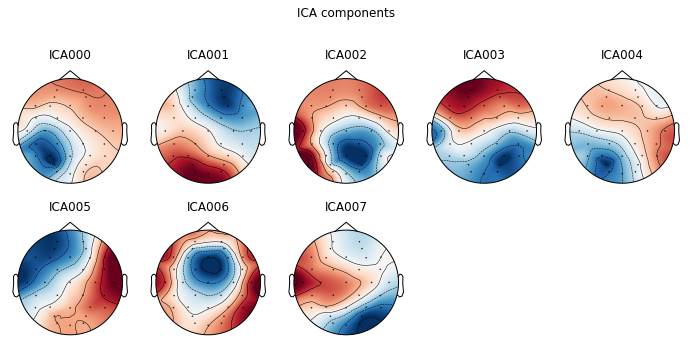

Figure(702x357.12)
Excluding 00 ICA component(s): []
Applying ICA to Epochs instance


C:\Users\thiag\AppData\Local\Temp/ipykernel_18840/3762223919.py:98: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  epochs_clean = ica.apply(epochs.copy())


    Transforming to ICA space (8 components)
    Zeroing out 0 ICA components
    Projecting back using 32 PCA components
Plotting PSD of epoched data
    Using multitaper spectrum estimation with 7 DPSS windows


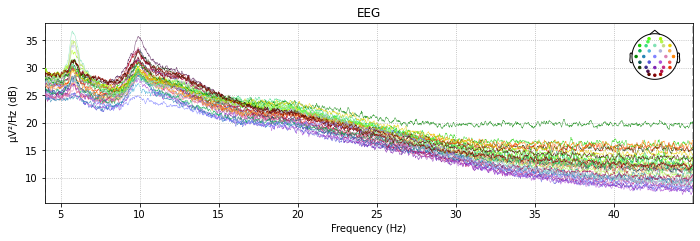

Saving ICA epoched data as .pkl file
Downsampling epoched data to 128Hz
Plotting PSD of epoched downsampled data
    Using multitaper spectrum estimation with 7 DPSS windows


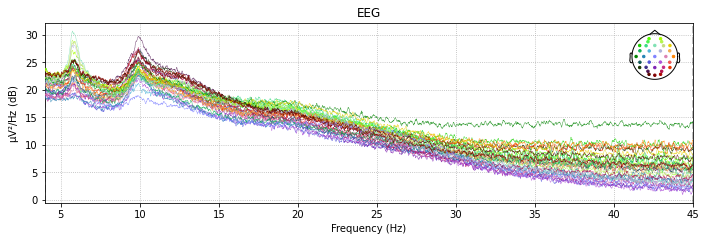

Original epoched data shape: (40, 32, 33281)
Downsampled epoched data shape: (40, 32, 8320)

Preparing EEG channel reordering to comply with the Geneva order
Picking source (raw) channel #01 to fill target (npy) channel #01 | Electrode position: Fp1
Picking source (raw) channel #02 to fill target (npy) channel #02 | Electrode position: AF3
Picking source (raw) channel #04 to fill target (npy) channel #03 | Electrode position: F3
Picking source (raw) channel #03 to fill target (npy) channel #04 | Electrode position: F7
Picking source (raw) channel #06 to fill target (npy) channel #05 | Electrode position: FC5
Picking source (raw) channel #05 to fill target (npy) channel #06 | Electrode position: FC1
Picking source (raw) channel #08 to fill target (npy) channel #07 | Electrode position: C3
Picking source (raw) channel #07 to fill target (npy) channel #08 | Electrode position: T7
Picking source (raw) channel #10 to fill target (npy) channel #09 | Electrode position: CP5
Picking source (ra

C:\Users\thiag\AppData\Local\Temp/ipykernel_18840/3762223919.py:145: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  trial_id = ratings_subj[is_exp]['Trial'].values[0]


Raw EEG has been filtered, common average referenced, epoched, artifact-rejected, downsampled, trial-reordered and channel-reordered.
Finished.


In [31]:
data = clean_bdf(1)

In [32]:
data.shape

(32, 8320)